In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables (use either prepare function based on your version of SQLAlchemy)

# Option 1:
# Base.prepare(autoload_with=engine)

# Option 2:
Base.prepare(engine, reflect=True)


In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [15]:
def str_to_date(in_string):
# Convert a date stored as a string from the database and convert it to a datetime object.
# Input string format: YYYY-MM-DD
    out_date = dt.datetime.strptime(in_string, '%Y-%m-%d')
    return dt.date(out_date.year, out_date.month, out_date.day)

def last_12_months(date_string):
# Return the most recent date and a date a year ago from the most recent date
# Input: date in string format YYYY-MM-DD
# Output 1: most recent date (datetime)
# Output 2: date a year from the most recent date (datetime)

    # Convert string to datetime
    most_recent_date = str_to_date(date_string)

    # Print most recent date in the dataset
    print(f"Most recent date in table: {most_recent_date}")

    # Design a query to retrieve the last 12 months of precipitation data and plot the results.
    # Starting from the most recent data point in the database. Calculate the date one year from the last date in data set.
    most_recent_date_plus_1y = dt.date(most_recent_date.year - 1, most_recent_date.month, most_recent_date.day)
    print(f"One year from most recent date: {most_recent_date_plus_1y}")

    return most_recent_date, most_recent_date_plus_1y

In [16]:
# Find the most recent date in the dataset
most_recent_date_string = session.query(measurement).order_by(desc(measurement.date)).first().date
most_recent_date, most_recent_date_plus_1y = last_12_months(most_recent_date_string)

Most recent date in table: 2017-08-23
One year from most recent date: 2016-08-23


In [17]:
# Query the data ordered by date in descending order (most recent to least recent)
measurement_new_to_old = session.query(measurement).order_by(desc(measurement.date))

# Create empty lists
dates = []
prcps = []

# Loop through the measurements
for row in measurement_new_to_old:
    # Convert date to datetime
    row_date = str_to_date(row.date)
    
    # If the date is more recent than the limit date (1 year from most recent date)
    # and the precipitations values are not null...
    if (row_date >= most_recent_date_plus_1y) & (type(row.prcp) == float):
        # ... then append the data to the lists
        dates.append(row_date)
        prcps.append(row.prcp)


,Date,Precipitations
0,2017-08-23,0.0
3,2017-08-23,11.4
1,2017-08-23,0.0
2,2017-08-23,2.0
6,2017-08-22,12.7
...,...,...
2016,2016-08-23,3.8
2017,2016-08-23,1.3
2018,2016-08-23,0.5
2019,2016-08-23,45.5


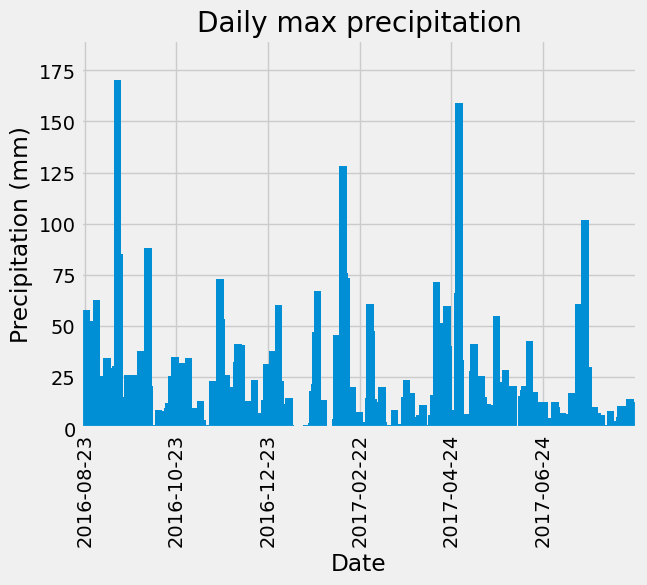

In [18]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names. Sort the DataFrame by date
measurements_df = pd.DataFrame({'Date': dates, 'Precipitations': prcps}).sort_values('Date', ascending=False)
display(measurements_df)

# Group by date and calculate the maximum precipitation
max_prcp_per_month = measurements_df.groupby('Date').max()

# Number of ticks
N = 6

# Ticks range and locations
L = len(max_prcp_per_month)
x_axis = [i*L/N for i in range(N)]
tick_location = [max_prcp_per_month.iloc[int(x)].name for x in x_axis]

# Plot the precipitations per day
max_prcp_per_month.plot.bar(width=5, ylabel='Precipitation (mm)', legend = False, title = 'Daily max precipitation')
plt.xticks(x_axis, tick_location,rotation=90)
plt.ylim(0,190)
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurements_df.describe()

,Precipitations
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
station_count_station = session.query(station).count()
print(f"There are {station_count_station} stations in the station table")

station_count_measurement = session.query(measurement.station).distinct().count()
print(f"There are {station_count_measurement} stations in the measurement table")

There are 9 stations in the station table
There are 9 stations in the measurement table


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Get the station and count of rows
station_activity = session.query(measurement.station, func.count(measurement.station))

# Group by station to get the count per station
station_activity = station_activity.group_by(measurement.station)

# Order by count of station (in descending order)
station_activity = station_activity.order_by(desc(func.count(measurement.station)))

# Return the result as a list
station_activity = station_activity.all()

# Display the list with each station with the count of rows in which it appears
display(station_activity)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Get the most active station (first item of the first row)
most_active_station = station_activity[0][0]
print(f"The most active station is: Station {most_active_station}")

sel = [measurement.station,
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)]

# Get the station, and temperature min, max and average
most_active_station_data = session.query(*sel)

# Group by station and filter to get only the most active station
most_active_station_data = most_active_station_data.group_by(measurement.station).filter(measurement.station == most_active_station)

# Get the first row of the result (there is only one, the most active station)
most_active_station_data = most_active_station_data.first()
display(most_active_station_data)

# Display the data in a more human-friendly way
print(f"Station: {most_active_station_data[0]}")
print(f"Min. temperature: {most_active_station_data[1]} degC")
print(f"Max. temperature: {most_active_station_data[2]} degC")
print(f"Avg. temperature: {most_active_station_data[3]:.1f} degC")

The most active station is: Station USC00519281


('USC00519281', 12.2, 29.4, 22.03582251082252)

Station: USC00519281
Min. temperature: 12.2 degC
Max. temperature: 29.4 degC
Avg. temperature: 22.0 degC


Most recent date in table: 2017-08-18
One year from most recent date: 2016-08-18


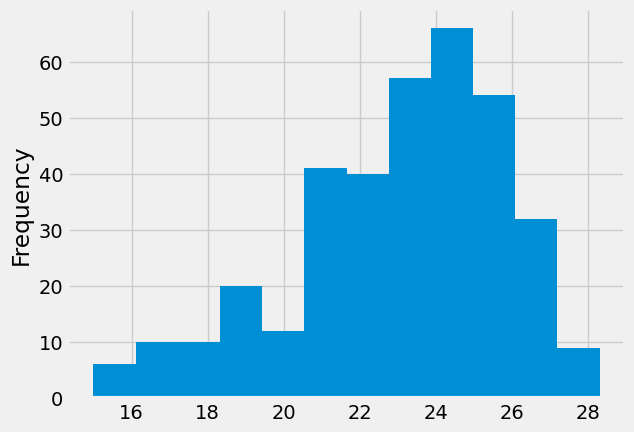

In [27]:
# Using the most active station id
most_active_station_query = session.query(measurement).filter(measurement.station == most_active_station).order_by(desc(measurement.date))

# Query the last 12 months of temperature observation data for this station
station_most_recent_date_string = most_active_station_query.first().date
station_most_recent_date, station_most_recent_date_plus_1y = last_12_months(station_most_recent_date_string)

# Create empty lists
station_dates = []
station_temps = []

# Loop through the measurements
for row in most_active_station_query:
    # Convert date to datetime
    row_date = str_to_date(row.date)
    
    # If the date is more recent than the limit date (1 year from most recent date)
    # and the precipitations values are not null...
    if (row_date >= station_most_recent_date_plus_1y) & (type(row.tobs) == float):
        # ... then append the data to the lists
        station_dates.append(row_date)
        station_temps.append(row.tobs)

# Save the data in a DataFrame
temperature_df = pd.DataFrame({'Date': station_dates, 'Temperature': station_temps})

# Plot the results in a histogram
temperature_df['Temperature'].plot.hist(bins=12, ylabel = 'Frequency', xlabel = 'Temperature (degC)')
plt.show()

# Close Session

In [14]:
# Close Session
session.close()